# Imports

In [60]:
# All imports

# General
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# For CNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For handling Images
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

# Tensorflow
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'1.14.0'

# Data Loading

In [61]:
# importing files
import zipfile
with zipfile.ZipFile('./Trafficdataset_Signtypes.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [62]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./Trafficdataset_Signtypes/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
TypeImagedata = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

# Inspecting Data

In [63]:
TypeImagedata.shape

(3699, 2)

In [64]:
TypeImagedata.label.unique()

array(['parking', 'stop', 'rightofway', 'warning', 'limitedtraffic',
       'noparking', 'speed', 'bicycle', 'giveway', 'traveldirection',
       'continue', 'crossing', 'trafficdirective', 'noentry', 'laneend',
       'roundabout'], dtype=object)

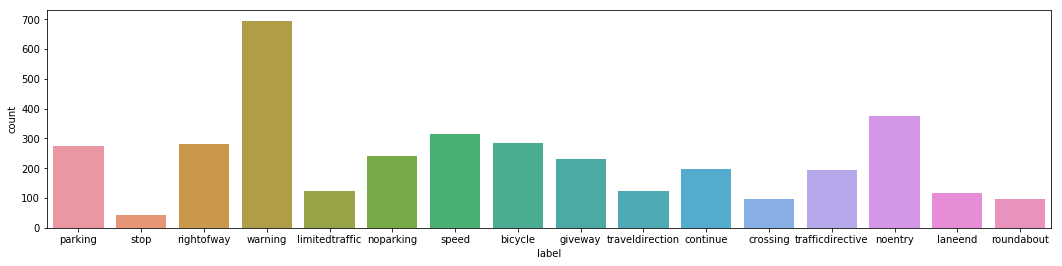

In [65]:
import seaborn as sns
plt.figure(figsize=(18,4))
sns.countplot(x='label', data=TypeImagedata)

# Dsiplay sample image

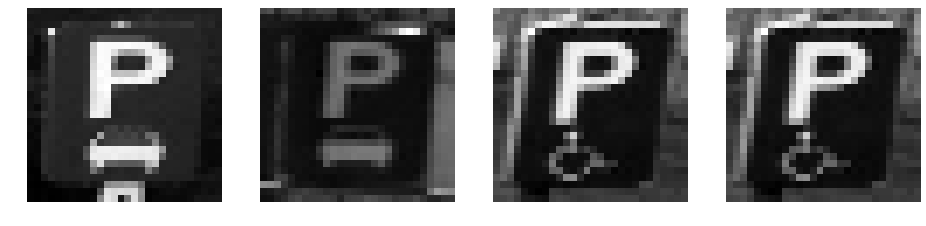

In [66]:
r_inx = np.random.choice(100, 4)
rand_data = TypeImagedata.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

# Label Mapping

In [67]:
d = {'parking':0, 'stop':1, 'rightofway':2, 'warning':3, 'limitedtraffic':4, 'noparking':5,
     'speed':6, 'bicycle':7, 'giveway':8, 'traveldirection':9, 'continue':10, 'crossing':11, 'trafficdirective':12,
     'noentry':13, 'laneend':14, 'roundabout':15}
TypeImagedata['labels_num'] = TypeImagedata['label'].map(d, na_action='ignore')

# Some other utility functions

In [68]:
def flatten(data):   
    l = []
    for i in range(len(data)):
        x = Image.open(data.iloc[i][0])
        x = np.array(x)
        l.append(x.flatten())
    return pd.DataFrame(np.array(l))

In [69]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res.history['loss'])
    plt.plot(res.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(res.history['categorical_accuracy'])
    plt.plot(res.history['val_categorical_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

# Image Classification using Random Forest

### Data Preprocessing  

- Splitting independent variables from the dependent variable in both training and testing

In [70]:
XData = TypeImagedata.iloc[:,0:1]
YData = TypeImagedata.labels_num

- Flattening the data

In [71]:
XData = flatten(XData)

- splitting total data into 80% training and 20% validation

In [72]:
x_train, x_test, y_train_v, y_test_v = train_test_split(XData,YData, test_size = 0.2, random_state = 2)

In [73]:
y_train_v =np.array(y_train_v) # converting to array

### Model Creation and training

In [74]:
rf = RandomForestClassifier(n_estimators = 10)

In [75]:
rf.fit(x_train,y_train_v)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### prediction

In [76]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

In [77]:
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))

print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))

Training metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00       227
           3       1.00      1.00      1.00       569
           4       1.00      1.00      1.00       104
           5       1.00      1.00      1.00       202
           6       1.00      1.00      1.00       252
           7       1.00      1.00      1.00       224
           8       1.00      1.00      1.00       174
           9       1.00      1.00      1.00        98
          10       1.00      1.00      1.00       171
          11       1.00      1.00      1.00        76
          12       1.00      0.99      1.00       151
          13       1.00      1.00      1.00       296
          14       1.00      1.00      1.00        92
          15       1.00      1.00      1.00        81

   micro avg       1.00      1.00      1.00      2959
   macro

In [78]:
print("Training Accuracy : ", accuracy_score(y_true= y_train_v, y_pred= y_pred_train))
print("Validation Accuracy : ", accuracy_score(y_true= y_test_v, y_pred= y_pred_test))

Training Accuracy :  0.9996620479891856
Validation Accuracy :  0.9135135135135135


### Grid Search with cross valdiation to tune hyper parameters

In [79]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [ 20, 30, 50, 80],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 4 ,6, 8],
    'n_estimators': [30, 50, 100, 120, 150]
}

In [80]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [42]:
grid_search.fit(x_train,y_train_v)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 17.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [20, 30, 50, 80], 'max_features': [2, 3, 4], 'min_samples_leaf': [2, 3, 4], 'min_samples_split': [2, 4, 6, 8], 'n_estimators': [30, 50, 100, 120, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [81]:
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

### Training optimized model using best parameters

In [82]:
rf = RandomForestClassifier(bootstrap=True, max_depth=30, max_features=4,
                            min_samples_leaf=2, min_samples_split=2,n_estimators=150)                                                

In [83]:
rf.fit(x_train,y_train_v)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

In [85]:
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))

print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))

Training metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00       227
           3       1.00      1.00      1.00       569
           4       1.00      1.00      1.00       104
           5       1.00      1.00      1.00       202
           6       1.00      1.00      1.00       252
           7       1.00      1.00      1.00       224
           8       1.00      1.00      1.00       174
           9       1.00      1.00      1.00        98
          10       1.00      1.00      1.00       171
          11       1.00      1.00      1.00        76
          12       1.00      1.00      1.00       151
          13       1.00      1.00      1.00       296
          14       1.00      1.00      1.00        92
          15       1.00      1.00      1.00        81

   micro avg       1.00      1.00      1.00      2959
   macro

In [86]:
print("Training Accuracy : ", accuracy_score(y_true= y_train_v, y_pred= y_pred_train))
print("Validation Accuracy : ", accuracy_score(y_true= y_test_v, y_pred= y_pred_test))

Training Accuracy :  1.0
Validation Accuracy :  0.9364864864864865


# Image classification using SVM (Support Vector Machine)

- We are going to be implementing kernel SVM 

### Data Preprocessing  

- Splitting independent variables from the dependent variable in both training and testing

In [87]:
XData = TypeImagedata.iloc[:,0:1]
YData = TypeImagedata.labels_num

- Flattening the data

In [88]:
XData = flatten(XData)

- splitting total data into 80% training and 20% validation

In [89]:
x_train, x_test, y_train_v, y_test_v = train_test_split(XData, YData, test_size = 0.2, random_state = 2)

In [90]:
y_train_v =np.array(y_train_v) # converting to array

### Model Creation and Prediction

In [91]:
svclassifier = SVC(kernel='poly', degree=2, gamma='auto')
svclassifier.fit(x_train,y_train_v)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
y_pred_train = svclassifier.predict(x_train)
y_pred_test = svclassifier.predict(x_test)

In [93]:
print("Training Accuracy : ", accuracy_score(y_true= y_train_v, y_pred= y_pred_train))
print("Validation Accuracy : ", accuracy_score(y_true= y_test_v, y_pred= y_pred_test))

Training Accuracy :  1.0
Validation Accuracy :  0.9445945945945946


In [95]:
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))

print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))

Training metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00       227
           3       1.00      1.00      1.00       569
           4       1.00      1.00      1.00       104
           5       1.00      1.00      1.00       202
           6       1.00      1.00      1.00       252
           7       1.00      1.00      1.00       224
           8       1.00      1.00      1.00       174
           9       1.00      1.00      1.00        98
          10       1.00      1.00      1.00       171
          11       1.00      1.00      1.00        76
          12       1.00      1.00      1.00       151
          13       1.00      1.00      1.00       296
          14       1.00      1.00      1.00        92
          15       1.00      1.00      1.00        81

   micro avg       1.00      1.00      1.00      2959
   macro

# Image classification using Convolutional Neural Network

Its time for neural network now (saved the best for the last) as they are proved to perform exceptionally well on image classification problems

### Train Test split

- splitting total data into 80% training and 20% validation

In [96]:
#generating training, testing and validation sets
trainData, testData = train_test_split(TypeImagedata ,test_size=0.20, random_state=42)

In [97]:
N_train_images = trainData.shape[0]
N_test_images = testData.shape[0]

### Image Data Generators 

- to augment the image and load into batches to increase computational efficiency

In [98]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

batch_size_t = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)


Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [99]:
# Class weights as the classes are unbalanced
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

### Design model

- starting with the most basic model (model version 1)

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(16))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

In [ ]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=20)

In [ ]:
plot_results(res)

In [ ]:
model_cnn.evaluate(test_generator)

### Model version 2

- Increasing the complexity of model by adding more layers (model version 2 of CNN)

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3)))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(16))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

In [ ]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=20)

In [ ]:
plot_results(res)

In [ ]:
model_cnn.evaluate(test_generator)

### Model Version 3 (FINAL)

- now since we have found a complex enough model now its time to incorporate regularisation, drop out and class weights

In [100]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(16))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
____

In [105]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=test_generator,class_weight=class_weights, epochs=25)

Epoch 1/25
185/185 [==============================] - 5s 27ms/step - loss: 0.4321 - categorical_accuracy: 0.8946 - val_loss: 0.2791 - val_categorical_accuracy: 0.9446
Epoch 2/25
185/185 [==============================] - 5s 27ms/step - loss: 0.4438 - categorical_accuracy: 0.8892 - val_loss: 0.3258 - val_categorical_accuracy: 0.9378
Epoch 3/25
185/185 [==============================] - 5s 27ms/step - loss: 0.4570 - categorical_accuracy: 0.8841 - val_loss: 0.2843 - val_categorical_accuracy: 0.9419
Epoch 4/25
185/185 [==============================] - 5s 27ms/step - loss: 0.4491 - categorical_accuracy: 0.8824 - val_loss: 0.2563 - val_categorical_accuracy: 0.9568
Epoch 5/25
185/185 [==============================] - 5s 27ms/step - loss: 0.4107 - categorical_accuracy: 0.8990 - val_loss: 0.2460 - val_categorical_accuracy: 0.9581
Epoch 6/25
185/185 [==============================] - 5s 27ms/step - loss: 0.4263 - categorical_accuracy: 0.8922 - val_loss: 0.3040 - val_categorical_accuracy: 0.931

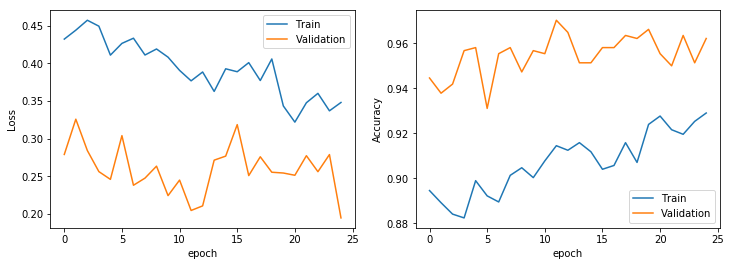

In [106]:
plot_results(res)


In [107]:
model_cnn.evaluate(test_generator)

740/740 [==============================] - 1s 2ms/step - loss: 0.1949 - categorical_accuracy: 0.9622


[0.1949286128922894, 0.96216214]

In [ ]:
# Independent evaluation

- The purpose of this is to test our best performing model on real world examples to realise whether if we can implement our current model in the real world environment or not

# unzipping files

import zipfile
with zipfile.ZipFile('./testdataapna.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Loading image path and labels
image_list = []
for filepath in glob.glob('./testdataapna/*/*.jpg', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
IndTestData = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

TestData.shape

Independent_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
Independent_test_generator = Independent_test_datagen.flow_from_dataframe(
        dataframe=IndTestData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)



labels = (Independent_test_generator.class_indices)

d_inv = {v: k for k, v in labels.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in Independent_test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        print(y_hat)
        print(y)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

model_cnn.evaluate(Independent_test_generator)